In [51]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)


In [139]:

data=pd.read_csv("data/transfusion_index.csv")
data["Bone"]=data["Bone"].map({"Yes":1,"No":0})
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
#factorize函数可以将Series中的标称型数据映射称为一组数字，相同的标称型映射为相同的数字
#factorize函数的返回值是一个tuple（元组），元组中包含两个元素。第一个元素是一个array，其中的元素是标称型元素映射为的数字；第二个元素是Index类型，其中的元素是所有标称型元素，没有重复。
#将type转化为"category"

for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('int32')
categorical_feats

['Race', 'Grade', 'N', 'Brain', 'Liver', 'Lung', 'Insurance', 'Marital']

In [140]:
#split就是特征在所有决策树中被用来分割的总次数。
#gain就是特征在所有决策树种被用来分割后带来的增益(gain)总和

def get_feature_importances(data, shuffle, seed=None):
    # 获取train
    train_features = [f for f in data if f not in ['Bone','ID']]
    y = data['Bone'].copy()
    #是否打乱
    if shuffle:
        y = data['Bone'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary'
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances:只在决策树以及以决策树为基础的算法中有
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [141]:
actual_imp_df = get_feature_importances(data,shuffle=False)

In [142]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,Age,12324.983277,2776,0.878867
1,Race,1233.424336,633,0.878867
2,Grade,22139.430621,571,0.878867
3,T,15092.335155,890,0.878867
4,N,22593.589365,236,0.878867


In [145]:
null_imp_df = pd.DataFrame()
nb_runs = 10
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)


Done with   10 of   10 (Spent   0.5 min)

In [151]:
#score features
#In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

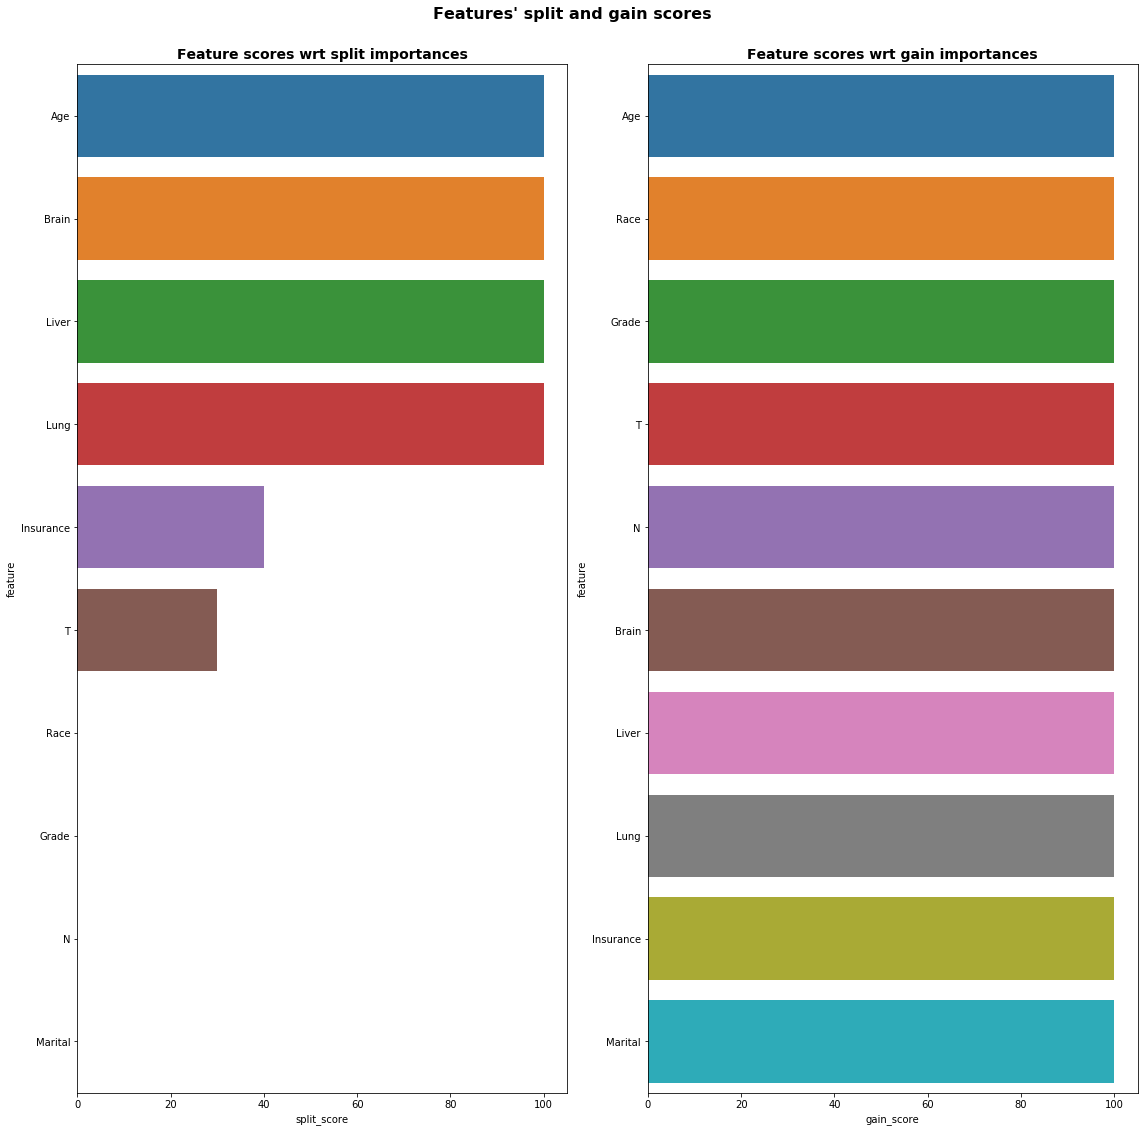

In [152]:
#打乱后的小于原来的25%才算重要
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)